In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import QuantileTransformer, Normalizer, LabelEncoder
import statsmodels.api as sm
%matplotlib inline

In [2]:
train = pd.read_csv('./../data/training.csv')

In [3]:
label = pd.read_csv('./../data/labels.csv', header=None)

In [4]:
train.head()

,Unnamed: 0,gasLimit_t,gasUsed_t,newContract,blockTime,difficulty,gasLimit_b,gasUsed_b,reward,size,...,avg_price_6,avg_blocktime_60,avg_gasUsed_b_60,avg_tx_count_60,avg_uncle_count_60,avg_difficulty_60,avg_txcnt_second_60,avg_gasUsed_t_60,avg_price_60,mv
0,0,50000,21000,0,10,2338428842518947,6732067,383005,5008232105000000000,2336,...,24.523604,24.45,5.768627e+06,94.616667,0.15,2.332719e+15,7.4,59403.370662,23.908728,0.932255
1,1,20967,9416,0,10,2338428842518947,6732067,383005,5008232105000000000,2336,...,24.523604,24.45,5.768627e+06,94.616667,0.15,2.332719e+15,7.4,59403.370662,23.908728,0.932255
2,2,50000,21000,0,10,2338428842518947,6732067,383005,5008232105000000000,2336,...,24.523604,24.45,5.768627e+06,94.616667,0.15,2.332719e+15,7.4,59403.370662,23.908728,0.932255
3,3,50000,21000,0,10,2338428842518947,6732067,383005,5008232105000000000,2336,...,24.523604,24.45,5.768627e+06,94.616667,0.15,2.332719e+15,7.4,59403.370662,23.908728,0.932255
4,4,50000,21000,0,10,2338428842518947,6732067,383005,5008232105000000000,2336,...,24.523604,24.45,5.768627e+06,94.616667,0.15,2.332719e+15,7.4,59403.370662,23.908728,0.932255


In [5]:
train.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
train.columns

Index([u'gasLimit_t', u'gasUsed_t', u'newContract', u'blockTime',
       u'difficulty', u'gasLimit_b', u'gasUsed_b', u'reward', u'size', u'type',
       u'totalFee', u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b',
       u'gweiShare', u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_blocktime_6', u'avg_gasUsed_b_6', u'avg_tx_count_6',
       u'avg_uncle_count_6', u'avg_difficulty_6', u'avg_txcnt_second_6',
       u'avg_gasUsed_t_6', u'avg_price_6', u'avg_blocktime_60',
       u'avg_gasUsed_b_60', u'avg_tx_count_60', u'avg_uncle_count_60',
       u'avg_difficulty_60', u'avg_txcnt_second_60', u'avg_gasUsed_t_60',
       u'avg_price_60', u'mv'],
      dtype='object')

In [7]:
train['type'].head()

0      tx
1    call
2      tx
3      tx
4      tx
Name: type, dtype: object

In [8]:
# label encode type 
le = LabelEncoder()
train['type_enc'] = le.fit_transform(train['type'])

In [9]:
train['type_enc'].value_counts()

2    967103
0    401896
1     27627
Name: type_enc, dtype: int64

In [10]:
label.columns = ['0', 'p_label2']

In [11]:
label.drop('0', axis=1, inplace=True)

In [12]:
train.dropna(inplace=True)

In [13]:
train.shape, label.shape

((1396626, 39), (1396626, 1))

In [14]:
y_label = np.ravel(label)

## Drop some features 
- that might cause data leakage
- that we don't have access to as inputs

In [15]:
train.columns

Index([u'gasLimit_t', u'gasUsed_t', u'newContract', u'blockTime',
       u'difficulty', u'gasLimit_b', u'gasUsed_b', u'reward', u'size', u'type',
       u'totalFee', u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b',
       u'gweiShare', u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_blocktime_6', u'avg_gasUsed_b_6', u'avg_tx_count_6',
       u'avg_uncle_count_6', u'avg_difficulty_6', u'avg_txcnt_second_6',
       u'avg_gasUsed_t_6', u'avg_price_6', u'avg_blocktime_60',
       u'avg_gasUsed_b_60', u'avg_tx_count_60', u'avg_uncle_count_60',
       u'avg_difficulty_60', u'avg_txcnt_second_60', u'avg_gasUsed_t_60',
       u'avg_price_60', u'mv', u'type_enc'],
      dtype='object')

Note: there is an API that estimates the amount of gas used, thus we have access to gasUsed_t

In [16]:
train.drop(['type', 
            'mv', 
            'blockTime', 
            'difficulty', 
            'gasLimit_b', 
            'gasUsed_b',
            'reward',
            'size',
            'totalFee',
            'gasShare',
            'gweiPaid',
            'gweiPaid_b',
            'gweiShare',
            'txcnt_second'], axis=1, inplace=True)

In [17]:
train.columns

Index([u'gasLimit_t', u'gasUsed_t', u'newContract', u'amount_gwei', u'free_t',
       u'day', u'hour', u'dayofweek', u'avg_blocktime_6', u'avg_gasUsed_b_6',
       u'avg_tx_count_6', u'avg_uncle_count_6', u'avg_difficulty_6',
       u'avg_txcnt_second_6', u'avg_gasUsed_t_6', u'avg_price_6',
       u'avg_blocktime_60', u'avg_gasUsed_b_60', u'avg_tx_count_60',
       u'avg_uncle_count_60', u'avg_difficulty_60', u'avg_txcnt_second_60',
       u'avg_gasUsed_t_60', u'avg_price_60', u'type_enc'],
      dtype='object')

## Prune out some more features

In [18]:
train.drop(['free_t',
           'newContract',
           'amount_gwei',
           'type_enc',
           'dayofweek',
           'day'], axis=1, inplace=True)

## Split data into training and test sets

In [19]:
X = train.values
y = y_label
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
X_train.shape, y_train.shape

((1047469, 19), (1047469,))

## Random forest regressor

In [21]:
def rf_regressor(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores = cross_val_score(rf, X_train, y_train, scoring='r2', cv=5)
    print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
    print('R2_score: {}'.format(r2_score(y_test, y_pred)))
    print('avg_CV_score: {}'.format(np.mean(scores)))
    # write predicted values to csv
    p = pd.DataFrame({'y_pred': y_pred})
    p.to_csv('./../data/label_pred.csv')
    return rf

In [22]:
model = rf_regressor(X_train, X_test, y_train, y_test)

MSE: 2.3527344475
R2_score: 0.99724959926
avg_CV_score: 0.997160603743


In [57]:
def plot_feature_importance(rf, feature_df):
    cols = []
    for col in feature_df.columns:
        cols.append(col)

    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=cols)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
    feat_scores.plot(kind='barh', color='r', figsize=(6,6))
    #plt.xlabel('Importance', fontsize=18)
    plt.title('Feature Importance', fontsize=18)
    plt.tight_layout()
    plt.savefig('./../images/feat_import_pruned.png', dpi=300)

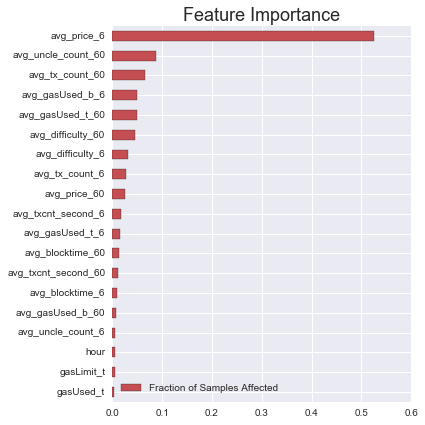

In [58]:
plot_feature_importance(model, train)

## Plot predicted values against labels

In [25]:
y_pred = pd.read_csv('./../data/label_pred.csv')

In [27]:
y_pred.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
y_pred.head()

,y_pred
0,7.632603
1,14.057899
2,5.622825
3,21.582008
4,12.142841


In [31]:
y_test.shape

(349157,)

In [45]:
y_pred = y_pred.values.ravel()

In [46]:
y_test.shape, y_pred.shape

((349157,), (349157,))

In [49]:
result = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [50]:
result.head()

,y_pred,y_test
0,7.632603,7.632342
1,14.057899,14.057899
2,5.622825,5.622825
3,21.582008,25.353080
4,12.142841,12.142869


(0, 100)

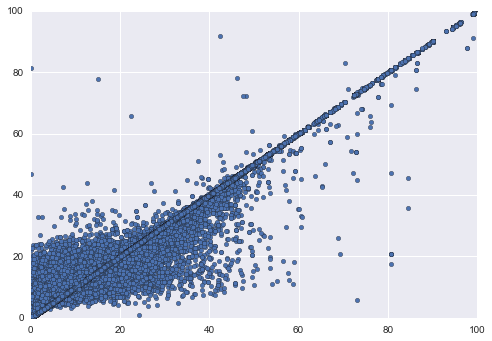

In [65]:
plt.scatter(result['y_test'], result['y_pred'])
plt.xlim(0,100)
plt.ylim(0,100)

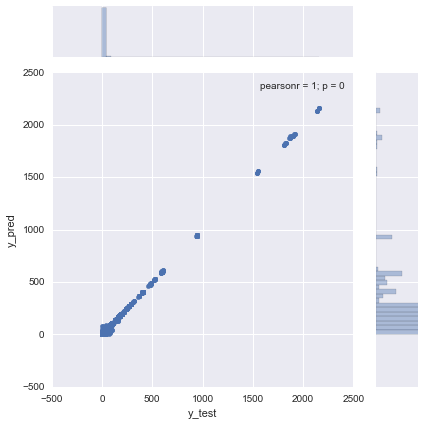

In [62]:
sns.set(style="darkgrid", color_codes=True)
sns.jointplot(x="y_test", y="y_pred", data=result)
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig('./../images/jointplot.png', dpi=300)

It looks like it is overfitting

## Plot model residuals

KeyboardInterrupt: 

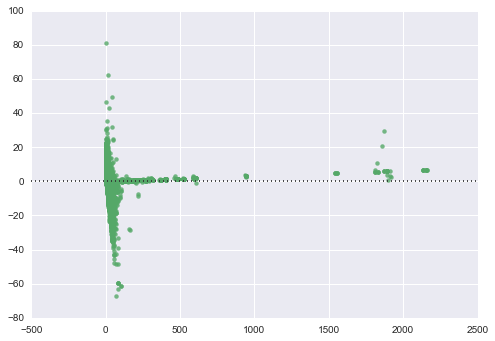

In [52]:
sns.residplot(result.y_test, result.y_pred , lowess=True, color="g")

In [66]:
def linear_regression(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
    print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
    print('R2_score: {}'.format(r2_score(y_test, y_pred)))
    print('avg_CV_score: {}'.format(np.mean(scores)))
    return lr

In [67]:
linear_regression(X_train, X_test, y_train, y_test)

MSE: 524.675830395
R2_score: 0.386641873865
avg_CV_score: 0.493296457359


//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [68]:
# get summary statistics from statsmodels
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                 1.155e+05
Date:                Tue, 03 Oct 2017   Prob (F-statistic):               0.00
Time:                        18:33:33   Log-Likelihood:            -4.7605e+06
No. Observations:             1047469   AIC:                         9.521e+06
Df Residuals:                 1047459   BIC:                         9.521e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.331e-07   6.06e-08      2.196      0.028    1.43e-08    2.52e-07
x2         -1.928e-06   1.63e-07    -11.845      0.000   -2.25e-06   -1.61e-06
x3            -0.0362      0.003    -10.705      0.000      -0.043      -0.030
x4             0.0708      0.002     28.366      0.000       0.066       0.076
x5          6.064e-07   3.15e-08     19.270      0.000    5.45e-07    6.68e-07
x6            -0.0270      0.001    -24.730      0.000      -0.029      -0.025
x7          -4.95e-05   1.72e-06    -28.735      0.000   -5.29e-05   -4.61e-05
x8          4.691e-16   3.53e-17     13.302      0.000       4e-16    5.38e-16
x9            -0.0077      0.004     -2.025      0.043      -0.015      -0.000
x10        -1.852e-06    5.1e-07     -3.636      0.000   -2.85e-06   -8.54e-07
x11            0.7153      0.001    862.578      0.000       0.714       0.717
x12            0.0160      0.000     35.579      0.000       0.015       0.017
x13        -1.938e-07   5.13e-08     -3.775      0.000   -2.94e-07   -9.32e-08
x14            0.0163      0.002      9.823      0.000       0.013       0.020
x15        -2.174e-05   4.68e-07    -46.486      0.000   -2.27e-05   -2.08e-05
x16        -3.034e-15   5.98e-17    -50.774      0.000   -3.15e-15   -2.92e-15
x17            0.0017      0.000      3.771      0.000       0.001       0.003
x18         2.406e-05   1.38e-06     17.486      0.000    2.14e-05    2.68e-05
x19           -0.0594      0.001    -41.299      0.000      -0.062      -0.057
==============================================================================
Omnibus:                  2151518.126   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      68067830551.167
Skew:                          16.411   Prob(JB):                         0.00
Kurtosis:                    1251.406   Cond. No.                     1.10e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+17. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All features show to be significant

### Check the rank of the feature matrix

In [70]:
from numpy.linalg import matrix_rank

In [84]:
X_train.shape

(1047469, 19)

In [71]:
matrix_rank(X_train)

3

It appears that our feature matrix is rank difficient and has a lot of colinearity